In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import json
import re
import os
import torchvision.transforms as tfs
import seaborn as sns
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from matplotlib import colors, pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, f1_score

DEVICE = torch.device("cuda")
TRAIN_DIR = Path('./train')
TEST_DIR = Path('./testset/testset')

RESCALE_SIZE = 224
BATCH_SIZE = 64


Тренировочные данные жестко не сбалантированы lionel_hutz=3, homer_simpson = 2246

In [ ]:
#===== Сформировать json =====
def natural_sort_key(path):
    match = re.search(r'img(\d+)\.', str(path))
    if match:
        return int(match.group(1))
    return 0

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
classes = [path.parent.name for path in train_val_files] 
train_val_labels = [path.parent.name for path in train_val_files]

def get_count(labels):
    df = pd.DataFrame(labels, columns=['name'])
    df['count'] = 1
    return df.groupby('name').count().sort_values('count')

df = get_count(train_val_labels)

C:\Users\homer\AppData\Local\Temp\ipykernel_20160\1544784023.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


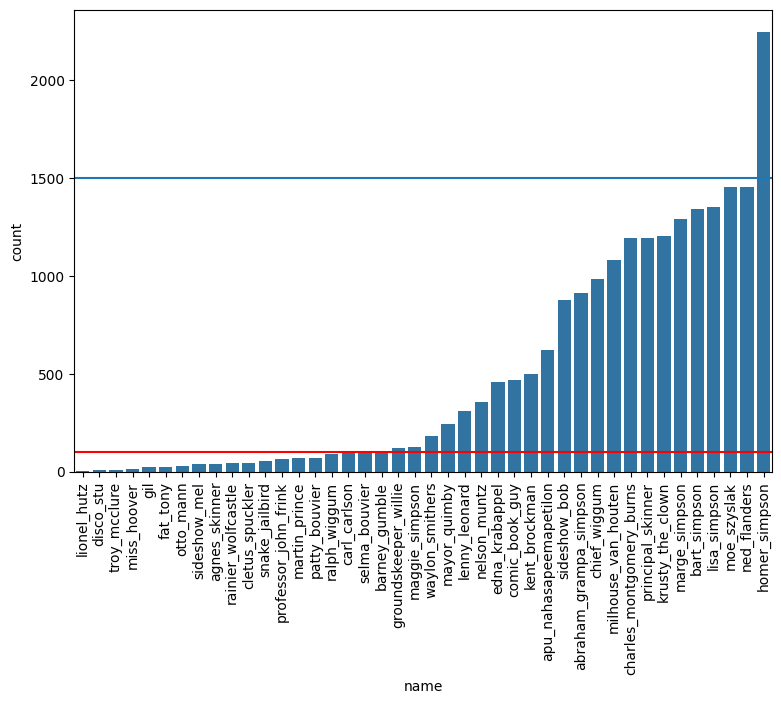

In [4]:
#===== Проверка распределения файлов =====
def show_data(data, min_level=True, max_level=True):
    plt.figure(figsize=(9, 6))
    sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)
    if max_level:
        plt.axhline(y=1500)
    if min_level:
        plt.axhline(y=100, color='red')
    plt.show()
    
show_data(df)

In [5]:
augmenters = {
    'Crop': transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250),
    ]),
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'ColorJitter': transforms.ColorJitter(
        brightness=0.2,    # случайное: изменение яркости (±20%)
        contrast=0.2,      # контраста (±20%)
        saturation=0.2,   # насыщенности (±20%)
        hue=0.1           # оттенка (±10%, работает только в RGB)
    ),
    'RandomAffine': transforms.RandomAffine(
        degrees=15,        # случайный: поворот (±15°)
        translate=(0.1, 0.1),  # случайный сдвиг (±10% по X и Y)
        scale=(0.9, 1.1),  # случайное масштабирование (от 90% до 110%)
        shear=10           # случайный наклон (±10°)
    ),
    'GaussianBlur': transforms.GaussianBlur(
        kernel_size=5,    # размер ядра размытия (должен быть нечётным)
        sigma=(0.1, 2.0)  # диапазон размытия (чем больше, тем сильнее)
    ),
}
def load_image(file):
    image = Image.open(file)
    image.load()
    return image

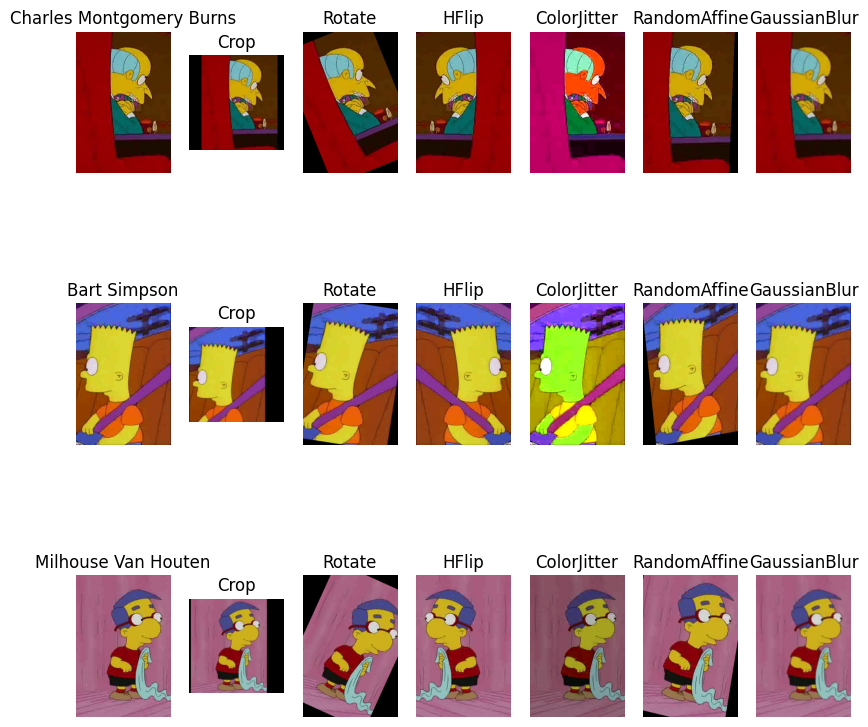

In [6]:
n_examples = 3

fig, ax = plt.subplots(nrows=n_examples, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(n_examples):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = load_image(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name

    img_label = " ".join(map(lambda x: x.capitalize(),\
                img_label.split('_')))
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

In [7]:
#===== Составляем сиписок файлов, кторые нужно расширить =====
import math
df['to_add'] = df['count'].apply(lambda x: 2200 - x if x < 2200 else 0)
df['file_in_one_iter'] = np.ceil(df['to_add'] / df['count']).astype(int)
df


,count,to_add,file_in_one_iter
name,,,
lionel_hutz,3,2197,733
disco_stu,8,2192,274
troy_mcclure,8,2192,274
miss_hoover,17,2183,129
gil,27,2173,81
fat_tony,27,2173,81
otto_mann,32,2168,68
sideshow_mel,40,2160,54
agnes_skinner,42,2158,52


In [ ]:
import random
c = []
for image_path in tqdm(train_val_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    
    if df.loc[character]['to_add'] <= 0:
        continue
    
    img = load_image(image_path)
    
    # сколько раз аугментировать файл (минимум из оставшегося to_add и file_in_one_iter)
    iterations = min(int(df.loc[character]['file_in_one_iter']), df.loc[character]['to_add'])
    
    for i in range(iterations):
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")
    
    df.loc[character, 'to_add'] -= iterations

100%|██████████| 20933/20933 [07:48<00:00, 44.69it/s]  


In [9]:
df

,count,to_add,file_in_one_iter
name,,,
lionel_hutz,3,0,733
disco_stu,8,0,274
troy_mcclure,8,0,274
miss_hoover,17,0,129
gil,27,0,81
fat_tony,27,0,81
otto_mann,32,0,68
sideshow_mel,40,0,54
agnes_skinner,42,0,52


C:\Users\homer\AppData\Local\Temp\ipykernel_20160\1544784023.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.barplot(x=data.index, y=data['count'], orient='v').set_xticklabels(data.index, rotation=90)


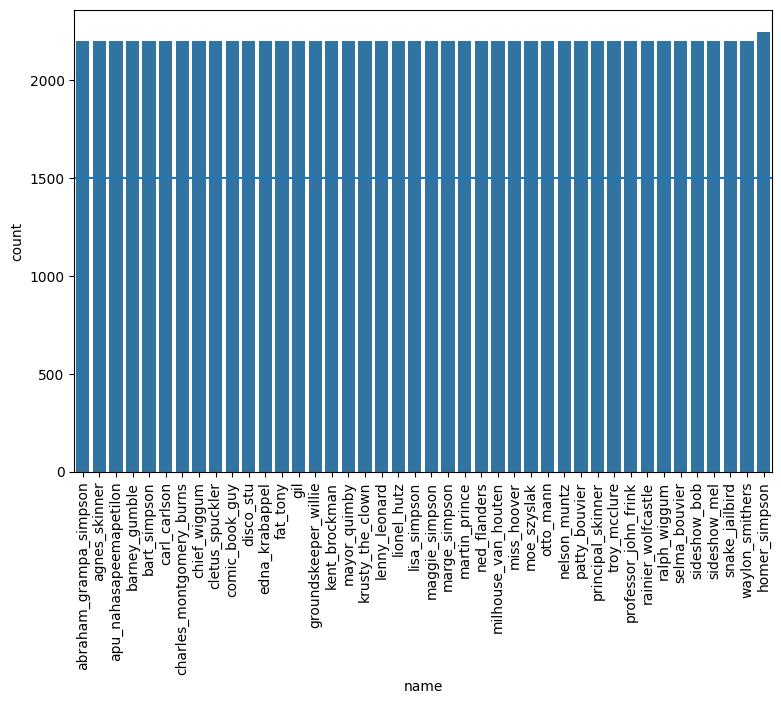

In [10]:
aug_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
aug_labels = [path.parent.name for path in aug_files]
aug_data = get_count(aug_labels)
show_data(aug_data, min_level=False)

========

In [26]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, root_path='', train=True, transforms=None):
        super().__init__()
        self.path = os.path.join(root_path, 'train' if train else 'testset\\testset')
        self.transform = transforms

        with open('labels.json','r') as f:
            self.format = json.load(f)

        self.len = 0
        self.files = []
        self.targets = torch.eye(42)
        self.is_train = train

        if train:
            for _dir, _targer in self.format.items():
                root_path = os.path.join(self.path, _dir)
                list_files = os.listdir(root_path)
                self.len += len(list_files)
                self.files.extend(map(lambda _x: (os.path.join(root_path, _x), _targer), list_files))
            # print(self.files)
        else:
            for _dir in sorted(os.listdir(self.path), key=self.natural_sort_key):
                # print(self.path, os.path.join(self.path, _dir))
                self.files.append(os.path.join(self.path, _dir))
            # print(self.files)
            self.len = len(self.files)



    def __len__(self):
        return self.len
    

    def _prepare_sample(self, image):
        return image.resize((RESCALE_SIZE, RESCALE_SIZE))  # PIL Image
    

    def __getitem__(self, index):
        if self.is_train:
            file_path, class_idx = self.files[index]
            target = self.targets[class_idx]
        else:
            file_path = self.files[index]
        
        self.img = Image.open(file_path).convert('RGB')
        # self.img = self._prepare_sample(self.img)
        
        if self.transform:
            self.img = self.transform(self.img)
        
        return (self.img, target) if self.is_train else self.img       

    
    @staticmethod
    def natural_sort_key(file_name):
        match = re.search(r'img(\d+)\.', str(file_name))
        if match:
            return int(match.group(1))
        return 0

In [27]:
FIRST_FE_COUNT = 32
SECOND_FE_COUNT = 64
TRIED_FE_COUNT = 128
PADDING = 'same'
MAXPOOL_KERNEL = 2

NERON_COUNT = 128

class SimpsonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=FIRST_FE_COUNT, kernel_size=3, stride=1, padding=PADDING, bias=False),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [natch, FIRST_FE_COUNT = 32, 112, 112]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, out_channels=SECOND_FE_COUNT, kernel_size=3, stride=1, padding=PADDING, bias=False),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [natch, SECOND_FE_COUNT = 64, 56, 56]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, out_channels=TRIED_FE_COUNT, kernel_size=3, stride=1, padding=PADDING, bias=False),
            nn.BatchNorm2d(TRIED_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [natch, TRIED_FE_COUNT = 128, 28, 28]

            nn.Flatten(), # [batch, 4*28*28 = 3136]

            nn.Linear(TRIED_FE_COUNT * 28 * 28, NERON_COUNT, bias=False),
            nn.ReLU(),
            nn.Linear(NERON_COUNT, 42, bias=False)
        )
        
        # self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        return self.net(x)

In [ ]:
transform = transforms.Compose([
    tfs.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.4628, 0.4084, 0.3533], [0.2557, 0.2335, 0.2645])
])

dataset = SimpsonsDataset(transforms=transform)
d_train, d_val = random_split(dataset, [0.8, 0.2])
train_data = DataLoader(d_train, batch_size=32,shuffle=True, drop_last=True)
valid_data = DataLoader(d_val, batch_size=32,shuffle=True, drop_last=True)

dataset.len

92446

In [29]:
#===== Начальные данные для обучения =====
model = SimpsonsModel().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
#===== Обчение + валидация =====
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, f1_score

EPOCHS = 20
lst_loss_train = []
lst_loss_val = []
best_val_loss = float('inf')
best_model_weights = None

# ======== Обучение ========
for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    train_tqdm = tqdm(train_data, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for batch in train_tqdm:
        data, target = batch[0].to(DEVICE), batch[1].to(DEVICE)
        
        # Forward
        predict = model(data)
        loss = loss_func(predict, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        epoch_train_loss += loss.item()
        _, predicted = torch.max(predict.data, 1)  # predicted shape: [32]
        total_train += target.size(0)

        target_ind_train = torch.argmax(target, dim=1)  # теперь shape: [32]
        correct_train += (predicted == target_ind_train).sum().item()
        # Обновление бара
        train_tqdm.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{100 * correct_train / total_train:.2f}%"
        })
    
    train_loss = epoch_train_loss / len(train_data)
    train_acc = 100 * correct_train / total_train
    
    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for val_batch in tqdm(valid_data, desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", leave=False):
            val_data, val_target = val_batch[0].to(DEVICE), val_batch[1].to(DEVICE)
            val_predict = model(val_data)
            val_loss += loss_func(val_predict, val_target).item()
            
            _, predicted_val = torch.max(val_predict.data, 1)
            total_val += val_target.size(0)

            target_ind_train = torch.argmax(val_target, dim=1)
            correct_val += (predicted_val == target_ind_train).sum().item()
            
            all_targets.extend(val_target.cpu().numpy())
            all_predictions.extend(predicted_val.cpu().numpy())
    
    val_loss /= len(valid_data)
    val_acc = 100 * correct_val / total_val
    
    
    # Сохраняем лучшую модель
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()
        torch.save(best_model_weights, 'best_model.tar')
    
    lst_loss_train.append(train_loss)
    lst_loss_val.append(val_loss)
    
    print(f"\nЭпоха {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")
    print("-" * 50)

# Вывод классификации для лучшей эпохи
print("\nОчет по валидации:")
print(classification_report(all_targets, all_predictions))


Эпоха 1/20
Train Loss: 3.7128 | Train Acc: 4.57%
Val Loss: 3.5219 | Val Acc: 5.84
--------------------------------------------------



Эпоха 2/20
Train Loss: 2.7953 | Train Acc: 25.05%
Val Loss: 1.7472 | Val Acc: 52.81
--------------------------------------------------



Эпоха 3/20
Train Loss: 1.2564 | Train Acc: 65.85%
Val Loss: 0.9568 | Val Acc: 74.90
--------------------------------------------------



Эпоха 4/20
Train Loss: 0.8008 | Train Acc: 78.12%
Val Loss: 0.7760 | Val Acc: 78.98
--------------------------------------------------



Эпоха 5/20
Train Loss: 0.6072 | Train Acc: 83.02%
Val Loss: 0.6230 | Val Acc: 83.11
--------------------------------------------------



Эпоха 6/20
Train Loss: 0.4939 | Train Acc: 86.12%
Val Loss: 0.5574 | Val Acc: 84.52
--------------------------------------------------



Эпоха 7/20
Train Loss: 0.4242 | Train Acc: 87.90%
Val Loss: 0.4852 | Val Acc: 86.77
--------------------------------------------------



Эпоха 8/20
Train Loss: 0.3771 | Train Acc: 89.21%
Val Loss: 0.4585 | Val Acc: 87.44
--------------------------------------------------



Эпоха 9/20
Train Loss: 0.3442 | Train Acc: 90.16%
Val Loss: 0.5066 | Val Acc: 86.37
--------------------------------------------------



Эпоха 10/20
Train Loss: 0.3212 | Train Acc: 90.91%
Val Loss: 0.4532 | Val Acc: 87.59
--------------------------------------------------



Эпоха 11/20
Train Loss: 0.3013 | Train Acc: 91.41%
Val Loss: 0.4499 | Val Acc: 87.91
--------------------------------------------------



Эпоха 12/20
Train Loss: 0.2862 | Train Acc: 91.82%
Val Loss: 0.4771 | Val Acc: 87.22
--------------------------------------------------



Эпоха 13/20
Train Loss: 0.2749 | Train Acc: 92.16%
Val Loss: 0.4097 | Val Acc: 89.17
--------------------------------------------------



Эпоха 14/20
Train Loss: 0.2673 | Train Acc: 92.40%
Val Loss: 0.4488 | Val Acc: 87.84
--------------------------------------------------



Эпоха 15/20
Train Loss: 0.2588 | Train Acc: 92.59%
Val Loss: 0.4123 | Val Acc: 88.84
--------------------------------------------------



Эпоха 16/20
Train Loss: 0.2515 | Train Acc: 92.85%
Val Loss: 0.3816 | Val Acc: 89.69
--------------------------------------------------



Эпоха 17/20
Train Loss: 0.2433 | Train Acc: 92.90%
Val Loss: 0.4388 | Val Acc: 88.47
--------------------------------------------------



Эпоха 18/20
Train Loss: 0.2432 | Train Acc: 92.96%
Val Loss: 0.3880 | Val Acc: 89.70
--------------------------------------------------



Эпоха 19/20
Train Loss: 0.2354 | Train Acc: 93.22%
Val Loss: 0.4376 | Val Acc: 88.53
--------------------------------------------------



Эпоха 20/20
Train Loss: 0.2281 | Train Acc: 93.41%
Val Loss: 0.4276 | Val Acc: 88.50
--------------------------------------------------

Очет по валидации:


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

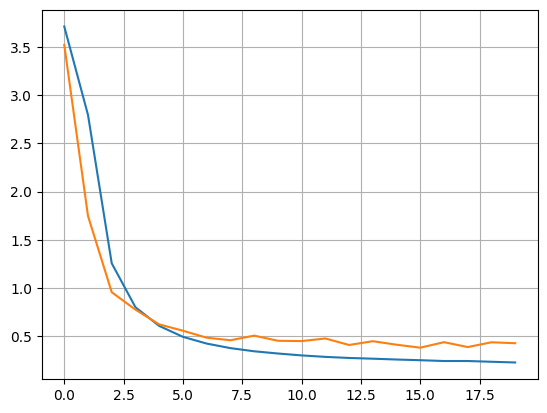

In [32]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()

In [33]:
#===== расчет Accuracy =====
test_train_data = DataLoader(dataset, batch_size=32,shuffle=True, drop_last=True)
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_train_data:
        x, y = x.to(DEVICE), y.to(DEVICE)
        outputs = model(x)
        # print(outputs)

        predicted = torch.max(outputs, 1).indices
        target_labels = torch.max(y, 1).indices
        
        total +=  y.size(0)
        correct += (predicted == target_labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy на полном тренировочном датасете: {accuracy:.2f}%') 


Accuracy на полном тренировочном датасете: 94.01%


In [34]:
#===== Сохранение обученой модели =====
st = model.state_dict()
torch.save(st, 'model_dnn2.tar')

Обработка тренировочных данных

In [35]:
transform = transforms.Compose([
    tfs.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.4628, 0.4084, 0.3533], [0.2557, 0.2335, 0.2645])
])

test_dataset = SimpsonsDataset(train=False ,transforms=transform)
test_data_loader = DataLoader(test_dataset, batch_size=32,shuffle=False)
model.eval()
logits = []
test_dataset.len
# with torch.no_grad():
#     for images in test_data_loader:
#         # print(images)
#         test_pred = model(images.to(DEVICE))
#         # predictions.extend(torch.max(outputs, 1).indices.cpu())
#         logits.append(outputs.cpu())
# # nn.functional.softmax(torch.cat(predictions), dim=-1)
# probs = nn.functional.softmax(torch.cat(logits), dim=-1)


991

In [36]:
# ===== Предсказание по тестовым данным и вывод сабмит =====
test_dataset = SimpsonsDataset(train=False, transforms=transform)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for images in test_data_loader:
        outputs = model(images.to(DEVICE))
        predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_files = [Path(f).name for f in test_dataset.files]
with open('labels.json') as f:
    label_map = json.load(f)
    
submission = pd.DataFrame({
    'Id': test_files,
    'Expected': [list(label_map.keys())[i] for i in predictions]
})

sample = pd.read_csv('sample_submission.csv')
    
submission.to_csv('my_submission.csv', index=False)